In [ ]:
####  If not GD, run from local starts here ##############

In [2]:
project_path="/FINDER_CM"

In [5]:
# magic line for local jupyter notebooks
%matplotlib inline

In [3]:
import time
import sys,os

import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm


# use old module functions
sys.path.append(f'{project_path}/FINDER-pytorch/code/FINDER_ND_CM/')
from FINDER import FINDER

old_finder = FINDER()

# HXA with maxcc
def HXA(g, method):
        # 'HDA', 'HBA', 'HPRA', 'HCA'
        sol = []
        G = g.copy()
        while (nx.number_of_edges(G)>0):
            if method == 'HDA':
                dc = nx.degree_centrality(G)
            elif method == 'HBA':
                dc = nx.betweenness_centrality(G)
            elif method == 'HCA':
                dc = nx.closeness_centrality(G)
            elif method == 'HPRA':
                dc = nx.pagerank(G)
            keys = list(dc.keys())
            values = list(dc.values())
            maxTag = np.argmax(values)
            node = keys[maxTag]
            sol.append(node)
            G.remove_node(node)
        solution = sol + list(set(g.nodes())^set(sol))
        solutions = [int(i) for i in solution]
        Robustness = old_finder.utils.getRobustness(old_finder.GenNetwork(g), solutions)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness,MaxCCList,solutions

# modified from original EvaluateSol
def EvaluateSol(g, sol_file, strategyID=0, reInsertStep=20):
        #evaluate the robust given the solution, strategyID:0,count;2:rank;3:multipy
        #sys.stdout.flush()
        # g = nx.read_weighted_edgelist(data_test)
        #g = nx.read_gml(data_test)
        g_inner = old_finder.GenNetwork(g)
        print('Evaluating FINDER model')
        print('number of nodes:%d'%nx.number_of_nodes(g))
        print('number of edges:%d'%nx.number_of_edges(g))
        nodes = list(range(nx.number_of_nodes(g)))
        sol = []
        for line in open(sol_file):
            sol.append(int(line))

        sol_left = list(set(nodes)^set(sol))
        if strategyID > 0:
            start = time.time()
            sol_reinsert = old_finder.utils.reInsert(g_inner, sol, sol_left, strategyID, reInsertStep)
            end = time.time()
            print ('reInsert time:%.6f'%(end-start))
        else:
            sol_reinsert = sol
        solution = sol_reinsert + sol_left
        print('number of solution nodes:%d'%len(solution))
        Robustness = old_finder.utils.getRobustness(g_inner, solution)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness, MaxCCList, solution


# load graph from ready to use gml (converted from datasets)
# Network names are: "Digg", "HI-II-14"
# Weight types are: 001, degree, random, zero
def build_graph_path(network_name,weight_type="001"):
    return f"{project_path}/FINDER-pytorch/data/real/cost/{network_name}_{weight_type}.gml"

# load solution files generated by model
# Network names are: "Digg", "HI-II-14"
# Model names are: FINDER_ND_cost, old_FINDER_ND_cost_tf etc.
# step_ratio are: 0.0100, etc.
# Weight types are: 001, degree, random, zero
def build_solution_path(network_name,model_name="FINDER_CN_cost",step_ratio="0.0100",weight_type="001"):
    data_folder=""
    if(weight_type!=""):
        weight_type=f"_{weight_type}"
        data_folder=f"Data{weight_type}/"
    return f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/{data_folder}StepRatio_{step_ratio}/{network_name}{weight_type}.txt"



/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




2022-03-30 20:32:13.863359: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-30 20:32:13.879060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-03-30 20:32:13.879885: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5606bf64ad30 executing computations on platform Host. Devices:
2022-03-30 20:32:13.879919: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-03-30 20:32:13.880307: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-30 20:32:13.880336: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 20:32:13.8

In [4]:
def get_node_weights(g):
    sum=0.0
    for i,v in g.nodes(data=True):
        sum+=v["weight"]
    return sum

# compute the ratio of cost of removed nodes / totol cost
# TODO, add step (or not, since it's test dataset, step is just trick at training stage)
def get_frac_cost_of_removed_nodes(g,solutions,ND_cost=False,verbose=0):
    num_nodes = nx.number_of_nodes(g) 
    if(ND_cost):
      total_weight = get_node_weights(g)
    else:
      total_weight = g.size()

    g_mod = g.copy()
    if(verbose>0):
        print("\nOriginal # of nodes: ",num_nodes)
        print("Original total weight: ",total_weight)
        print("Solution: ", len(solutions), " = ", solutions , "\n")

    frac_cost_list=[]
    for rm_node in tqdm(solutions):
    #for rm_node in reversed(solutions):
        g_mod.remove_node(rm_node)
        if(ND_cost):
          left_weight = get_node_weights(g_mod)
        else:
          left_weight = g_mod.size()

        frac_cost = (total_weight - left_weight) / total_weight
        frac_cost_list.append(frac_cost)
        if(verbose>1):
            print("Removed node: ", rm_node)
            print("left_weight: ", left_weight)
            print("Frac cost of removed nodes: ", frac_cost)
                
    return frac_cost_list



  2%|█▏                                                                              | 64/4165 [00:00<00:06, 633.20it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 61/4165 [00:00<00:06, 606.17it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 59/4165 [00:00<00:06, 588.45it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1165.92it/s]


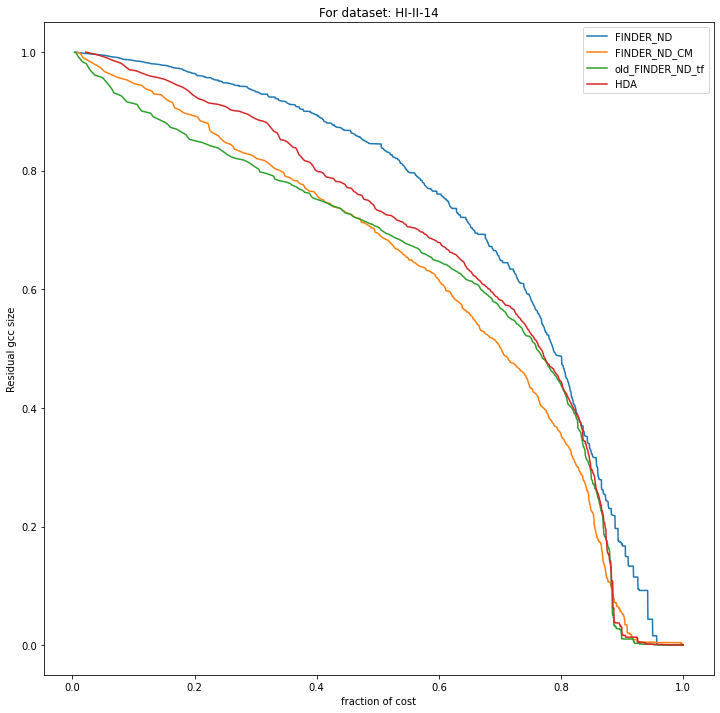

In [12]:

# plot
from matplotlib import pyplot as plt

cost_model_settings = ['FINDER_ND_cost','FINDER_ND_cost_CM','old_FINDER_ND_cost_tf','HDA']
model_settings = ['FINDER_ND','FINDER_ND_CM','old_FINDER_ND_tf','HDA']

datasets = ["HI-II-14","Yang-16","Yu-11","Venkatesan-09","H-I-05"]

def load_from_file(f):
    FINDER_f = open(f, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))

    return scores

def plot_graphs(dataset_name, model_settings):
    # load network
    g = nx.read_edgelist(f"{project_path}/FINDER-pytorch/data/real/{dataset_name}.txt", nodetype=int)
       
    plt.figure(figsize=(12,12))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            #print("From HDA:",HDA_robustness, HDA_maxcclist[0:5],HDA_solutions[0:5])
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/{dataset_name}.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/MaxCCList_Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=model_name)
            #plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=f"{model_name} from file")

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND models f: {dataset_name}")
    plt.show()

plot_graphs("HI-II-14",model_settings)

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9688.40it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9732.15it/s]


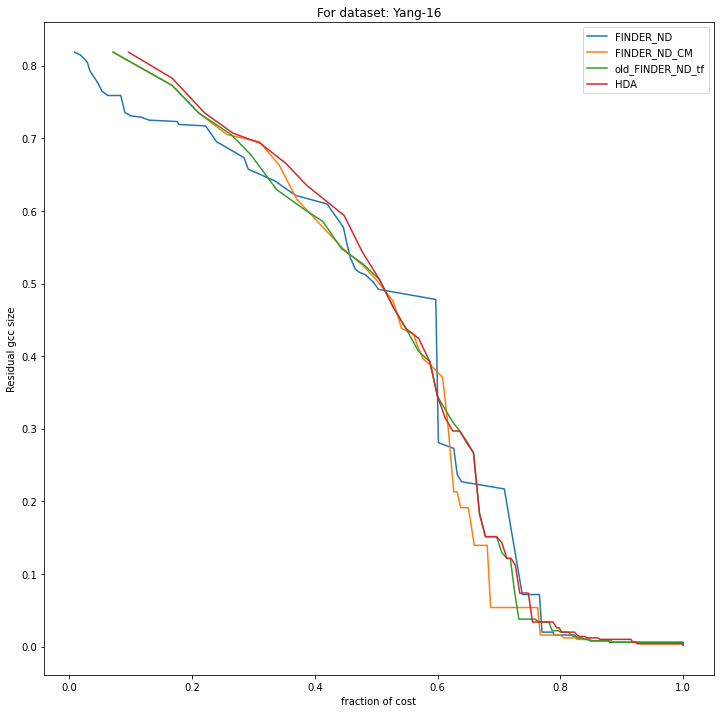

In [13]:
plot_graphs("Yang-16",model_settings)

  1%|█▏                                                                              | 61/4165 [00:00<00:06, 602.55it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 64/4165 [00:00<00:06, 637.32it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 63/4165 [00:00<00:06, 625.64it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1225.82it/s]


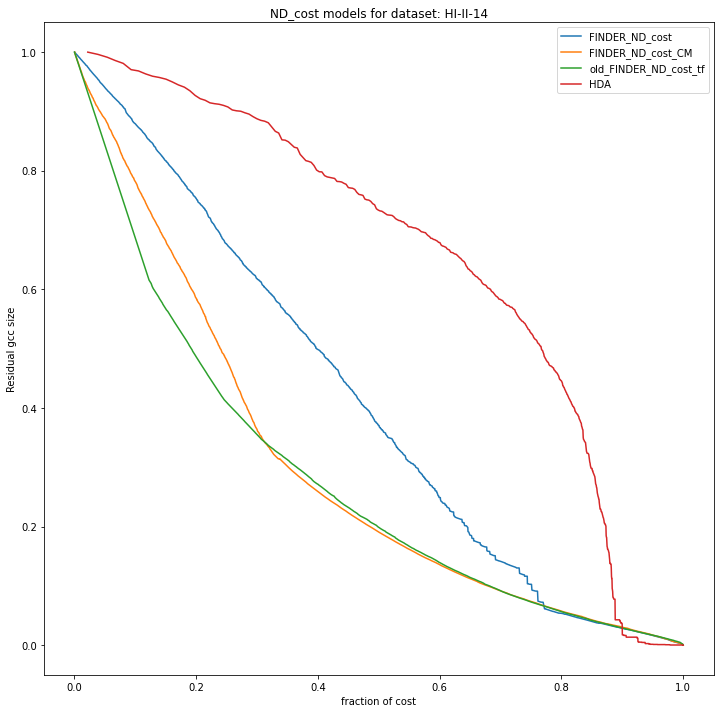

In [18]:
def plot_cost_graphs(dataset_name, model_settings):
    # load network
    g = nx.read_gml(f"{project_path}/FINDER-pytorch/data/real/cost/{dataset_name}_degree.gml",destringizer=int)
       
    plt.figure(figsize=(12,12))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            #print("From HDA:",HDA_robustness, HDA_maxcclist[0:5],HDA_solutions[0:5])
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/{dataset_name}_degree.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/MaxCCList__Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=model_name)
            #plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=f"{model_name} from file")

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND_cost models for dataset: {dataset_name}")
    plt.show()
    
plot_cost_graphs("HI-II-14",cost_model_settings)

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9541.45it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9655.83it/s]


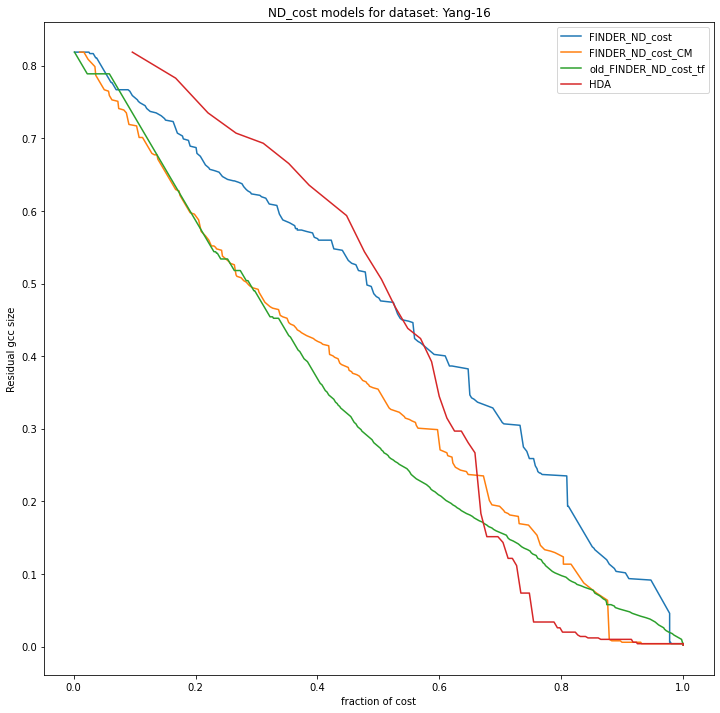

In [19]:
plot_cost_graphs("Yang-16",cost_model_settings)

  1%|█▏                                                                              | 61/4165 [00:00<00:06, 600.15it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 619.25it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 611.05it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1193.24it/s]


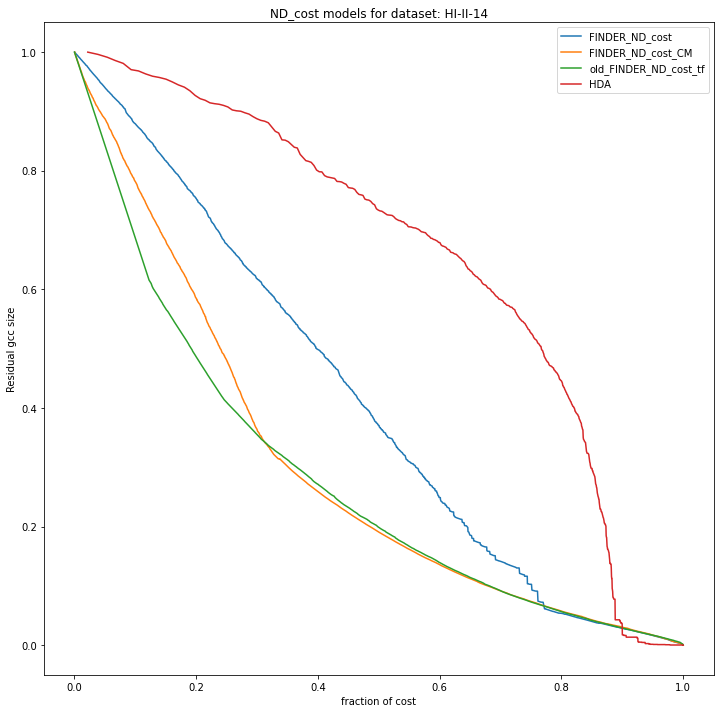

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9676.24it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502



100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9495.11it/s]


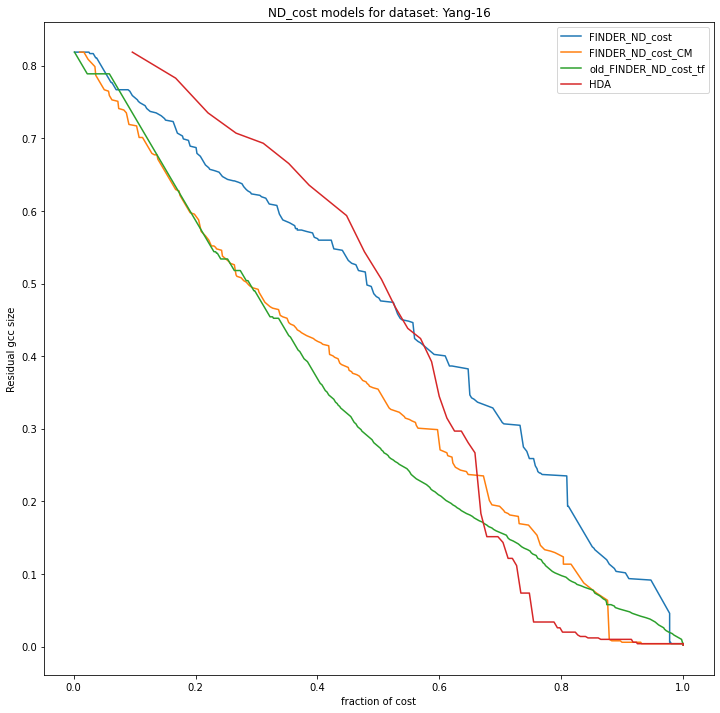

 22%|█████████████████▌                                                            | 254/1132 [00:00<00:00, 2536.43it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2591.77it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|██████████████████                                                            | 263/1132 [00:00<00:00, 2623.02it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


100%|█████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 4505.52it/s]


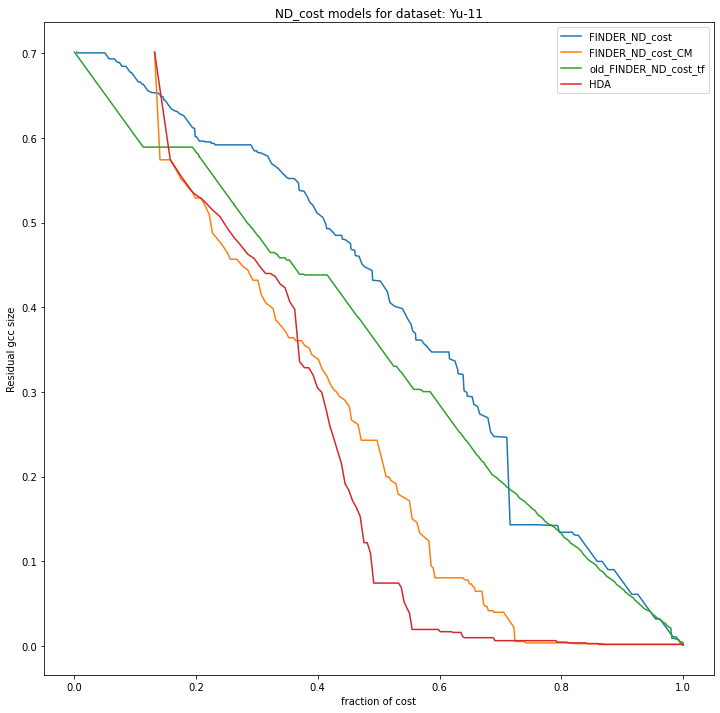

100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 22231.90it/s]

Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195


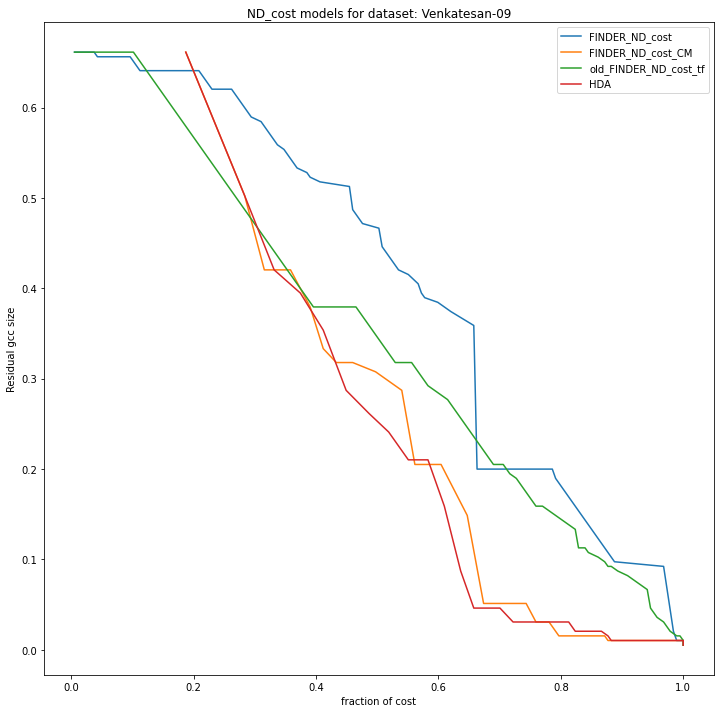

 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1819.32it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▌                                                                    | 184/1504 [00:00<00:00, 1835.80it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1818.74it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


100%|█████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 3306.21it/s]


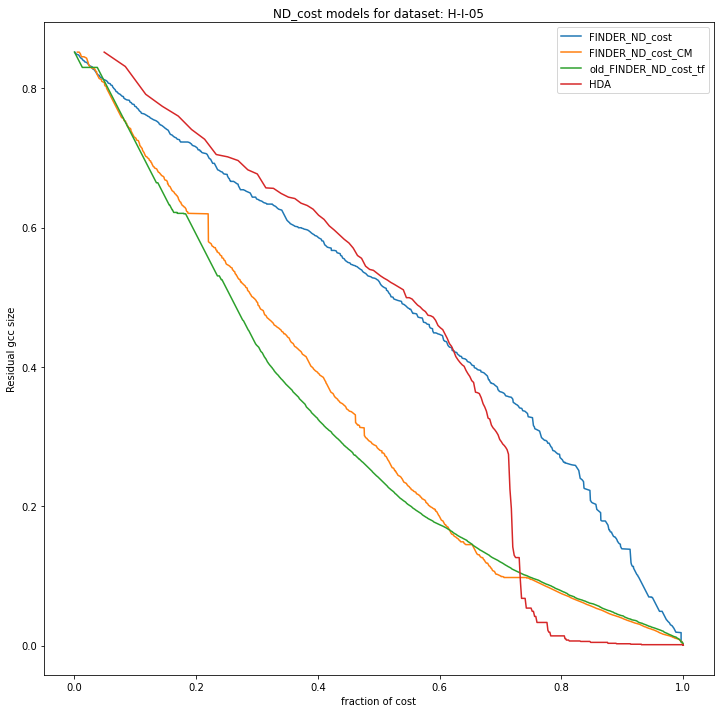

In [20]:
for dataset in datasets:
    plot_cost_graphs(dataset,cost_model_settings)